In [1]:
import os, sys
import pickle 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

# 0. Prepare Data

In [2]:
os.chdir("/home/laiy/gitrepos/msr_final/LongTermEMG_myo")
# from PrepareAndLoadData.process_data import read_data_training
from PrepareAndLoadData.process_data import format_examples

In [3]:
data_dir = "/home/laiy/gitrepos/msr_final/Wearable_Sensor_Long-term_sEMG_Dataset/data"
processed_data_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Processed_datasets"
code_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo"
save_dir = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/Results"

In [4]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=3)

In [5]:

pos = ['N', 'I', 'O', 'N', 'I', 'I', 'O', 'O', 'N', 'N',      # 1-10th day 
      'O', 'N', 'N', 'O', 'O', 'I', 'I', 'I', 'N', 'O',       # 11-20th day
      'O', 'I', 'O', 'I', 'I', 'N', 'N', 'I', 'N', 'O']       # 21-30th day

pos_label = [1, 2, 3, 1, 2, 2, 3, 3, 1, 1,
            3, 1, 1, 3, 3, 2, 2, 2, 1, 3,
            3, 2, 3, 2, 2, 1, 1, 2, 1, 3] # N: 1, I: 2, O: 3
# days correspond to N, I, and O positions
sessions_idx = [[],[],[]]
for idx, pl in enumerate(pos_label):
    sessions_idx[pl-1].append(idx+1)

day_num = 30
sub_num = 5
mov_num = 22
fs = 200
ch_num = 8
trial_num = 4

win_size = 30            # 300ms window
win_inc = 5             # 50ms overlap

In [6]:
def read_files_to_format_training_session(path_folder_examples, day_num,
                                          number_of_cycles, number_of_gestures, window_size,
                                          size_non_overlap):
    """
    path_folder_examples: path to load training data
    feature_set_function
    number_of_cycles: number of trials recorded for each motion
    number_of_gestures
    window_size: analysis window size
    size_non_overlap: length of non-overlap portion between each analysis window
    
    shape(formated_example) = (26, 50, 8)
    """
    examples_training, labels_training = [], []
    
    for cycle in range(1, number_of_cycles+1):
        examples, labels = [], []
        for gesture_index in range(1, number_of_gestures+1):
            read_file = path_folder_examples + "/D" + str(day_num) + "M" + str(gesture_index) + "T" + str(cycle) + ".csv"
            # print("      READ ", read_file)
            # skipping odd number rows to have freq = 100Hz
            examples_to_format = pd.read_csv(read_file, header=None, skiprows=lambda x: x%2 == 1).to_numpy()
            # each file contains 15s (300 rows) of 8 channel signals 
            # print("            data = ", np.shape(examples_to_format))
            
            examples_formatted = format_examples(examples_to_format,
                                     window_size=window_size,
                                     size_non_overlap=size_non_overlap)
            # print("            formated = ", np.shape(examples_formatted))

            examples.extend(examples_formatted)
            labels.extend(np.ones(len(examples_formatted)) * (gesture_index-1))
            
        # print("   SHAPE SESSION ", cycle, " EXAMPLES: ", np.shape(examples))
        examples_training.append(examples)
        labels_training.append(labels)
        # print("   SHAPE ALL SESSION EXAMPLES: ", np.shape(examples_training))  

    return examples_training, labels_training


In [7]:
def get_data_and_process_it_from_file(path, number_of_gestures=22, number_of_cycles=4, window_size=50, 
                                        size_non_overlap=10, num_participant=5):

    """
    Args:
        path: path to load training data
        number_of_gestures
        number_of_cycles: number of trials recorded for each motion
        window_size: analysis window size
        size_non_overlap: length of non-overlap portion between each analysis window

    Returns:
        loaded data dictionary containing `examples_training` and `labels_training`
    """
    examples_training_sessions_datasets, labels_training_sessions_datasets = [], []

    # load one participant for now
    for index_participant in range(1,1+num_participant):
        # load one participant data 
        folder_participant = "sub" + str(index_participant)
        examples_participant_training_sessions, labels_participant_training_sessions = [], []
        for days_of_current_session in sessions_idx:
            print("process data in days ", days_of_current_session)
            examples_per_session, labels_per_session = [], []
            for day_num in days_of_current_session:
                path_folder_examples = path + "/" + folder_participant + "/day" + str(day_num)
                # print("current dr = ", day_num)
                
                examples_training, labels_training  = \
                    read_files_to_format_training_session(path_folder_examples=path_folder_examples,
                                                        day_num = day_num,
                                                        number_of_cycles=number_of_cycles,
                                                        number_of_gestures=number_of_gestures,
                                                        window_size=window_size,
                                                        size_non_overlap=size_non_overlap)
                examples_per_session.extend(examples_training)
                labels_per_session.extend(labels_training)
            examples_participant_training_sessions.append(examples_per_session)
            labels_participant_training_sessions.append(labels_per_session)
            print("@ traning sessions = ", np.shape(examples_participant_training_sessions))


        # participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572) x window_size x channel_num
        print('traning examples ', np.shape(examples_participant_training_sessions))
        examples_training_sessions_datasets.append(examples_participant_training_sessions)
        print('all traning examples ', np.shape(examples_training_sessions_datasets))

        # participants_num x sessions_num(3) x days_per_session(10)*trail_per_day(4) x #examples_window*#mov(26*22=572)
        print('traning labels ', np.shape(labels_participant_training_sessions))
        labels_training_sessions_datasets.append(labels_participant_training_sessions)
        print('all traning labels ', np.shape(labels_training_sessions_datasets))
    
    # store processed data to dictionary
    dataset_dictionnary = {"examples_training": np.array(examples_training_sessions_datasets, dtype=object),
                        "labels_training": np.array(labels_training_sessions_datasets, dtype=object)}
    return dataset_dictionnary

In [8]:
def read_data_training(path, store_path, number_of_gestures=22, number_of_cycles=4, window_size=50, 
                        size_non_overlap=10, num_participant=5):
    """
    path: path to load training data
    store_path: path to stored loaded data dictionary
        contains `examples_training` and `labels_training`
    number_of_gestures
    number_of_cycles: number of trials recorded for each motion
    window_size: analysis window size
    size_non_overlap: length of non-overlap portion between each analysis window
    num_participant: number of participant dataset to load
    """
    print("Loading and preparing Training datasets...")
    dataset_dictionnary = get_data_and_process_it_from_file(path=path, number_of_gestures=number_of_gestures,
                                                            number_of_cycles=number_of_cycles, window_size=window_size,
                                                            size_non_overlap=size_non_overlap, num_participant=num_participant)

    # store dictionary to pickle
    training_session_dataset_dictionnary = {}
    training_session_dataset_dictionnary["examples_training"] = dataset_dictionnary["examples_training"]
    training_session_dataset_dictionnary["labels_training"] = dataset_dictionnary["labels_training"]

    with open(store_path + "/training_session.pickle", 'wb') as f:
        pickle.dump(training_session_dataset_dictionnary, f, pickle.HIGHEST_PROTOCOL)


In [9]:
# read_data_training(path=data_dir, store_path = processed_data_dir, num_participant=3,
#                   window_size = 30, size_non_overlap = 5)

# 1. TSD_DNN

In [10]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_standard import \
            test_TSD_DNN_on_training_sessions, train_fine_tuning

In [11]:
# check stored pickle 
with open(processed_data_dir + "/training_session.pickle", 'rb') as f:
    dataset_training = pickle.load(file=f)

examples_datasets_train = dataset_training['examples_training']
print('traning examples ', np.shape(examples_datasets_train))
labels_datasets_train = dataset_training['labels_training']
print('traning labels ', np.shape(labels_datasets_train))

traning examples  (3, 3, 40, 550, 252)
traning labels  (3, 3, 40, 550)


In [12]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycle_for_first_training=40               # #session
number_of_cycles_rest_of_training=40     
path_to_save_to="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/TSD"
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

In [13]:
train_fine_tuning(examples_datasets_train, labels_datasets_train,
                  num_kernels=num_kernels, path_weight_to_save_to=path_to_save_to,
                  number_of_classes=number_of_classes,
                  batch_size=batch_size,
                  feature_vector_input_length=feature_vector_input_length,
                  learning_rate=learning_rate)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one grou

val Loss: 0.00021362 Acc: 0.98636364
Epoch 25 of 500 took 0.101s
Epoch 25/499
----------
train Loss: 0.00073431 Acc: 0.9703125
val Loss: 0.00018839 Acc: 0.99090909
Epoch 26 of 500 took 0.101s
Epoch 26/499
----------
train Loss: 0.00064744 Acc: 0.9734375
val Loss: 0.00013684 Acc: 0.99090909
Epoch 27 of 500 took 0.098s

Training complete in 0m 3s
Best val loss: 0.000213
Session:  1
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
      (dropout1): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): Linear(in_features=252, out_features=200, bias=True)
        (1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1, inplace=True)
        (3): Dropout(p

train Loss: 0.00879533 Acc: 0.70208333
val Loss: 0.00096966 Acc: 0.94090909
New best validation loss: 0.0009696642106229609
Epoch 1 of 500 took 0.123s
Epoch 1/499
----------
train Loss: 0.00332787 Acc: 0.85052083
val Loss: 0.00077164 Acc: 0.96363636
New best validation loss: 0.000771642340855165
Epoch 2 of 500 took 0.100s
Epoch 2/499
----------
train Loss: 0.00312712 Acc: 0.85989583
val Loss: 0.00043992 Acc: 0.98636364
New best validation loss: 0.00043991509486328474
Epoch 3 of 500 took 0.103s
Epoch 3/499
----------
train Loss: 0.00258813 Acc: 0.88385417
val Loss: 0.00051087 Acc: 0.97272727
Epoch 4 of 500 took 0.100s
Epoch 4/499
----------
train Loss: 0.00236105 Acc: 0.89427083
val Loss: 0.00034428 Acc: 0.98181818
Epoch 5 of 500 took 0.100s
Epoch 5/499
----------
train Loss: 0.00208343 Acc: 0.9125
val Loss: 0.00036418 Acc: 0.97727273
Epoch 6 of 500 took 0.109s
Epoch 6/499
----------
train Loss: 0.00203166 Acc: 0.91041667
val Loss: 0.00049069 Acc: 0.96818182
Epoch 7 of 500 took 0.102s
E

val Loss: 0.00026000 Acc: 0.98181818
New best validation loss: 0.00026000470600344916
Epoch 18 of 500 took 0.101s
Epoch 18/499
----------
train Loss: 0.00085618 Acc: 0.96458333
val Loss: 0.00019863 Acc: 0.99090909
Epoch 19 of 500 took 0.102s
Epoch 19/499
----------
train Loss: 0.00074469 Acc: 0.97291667
val Loss: 0.00019733 Acc: 0.99090909
Epoch 20 of 500 took 0.099s
Epoch 20/499
----------
train Loss: 0.00077810 Acc: 0.97083333
val Loss: 0.00020818 Acc: 0.99090909
Epoch 21 of 500 took 0.104s
Epoch 21/499
----------
train Loss: 0.00067376 Acc: 0.9765625
val Loss: 0.00018361 Acc: 0.99090909
Epoch 22 of 500 took 0.100s
Epoch 22/499
----------
train Loss: 0.00064919 Acc: 0.9765625
val Loss: 0.00019227 Acc: 0.98636364
Epoch 23 of 500 took 0.102s
Epoch 23/499
----------
train Loss: 0.00057657 Acc: 0.98177083
val Loss: 0.00020466 Acc: 0.99090909
Epoch 24 of 500 took 0.098s
Epoch 24/499
----------
train Loss: 0.00063349 Acc: 0.97708333
val Loss: 0.00018758 Acc: 0.99090909
Epoch 25 of 500 took

train Loss: 0.00261685 Acc: 0.8734375
val Loss: 0.00050196 Acc: 0.96818182
New best validation loss: 0.000501961430365389
Epoch 2 of 500 took 0.106s
Epoch 2/499
----------
train Loss: 0.00206882 Acc: 0.89375
val Loss: 0.00048371 Acc: 0.97272727
Epoch 3 of 500 took 0.115s
Epoch 3/499
----------
train Loss: 0.00205998 Acc: 0.8953125
val Loss: 0.00044639 Acc: 0.95909091
Epoch 4 of 500 took 0.104s
Epoch 4/499
----------
train Loss: 0.00190653 Acc: 0.90572917
val Loss: 0.00043852 Acc: 0.96818182
Epoch 5 of 500 took 0.099s
Epoch 5/499
----------
train Loss: 0.00159553 Acc: 0.92291667
val Loss: 0.00046110 Acc: 0.94090909
Epoch 6 of 500 took 0.098s
Epoch 6/499
----------
train Loss: 0.00154531 Acc: 0.93072917
val Loss: 0.00023927 Acc: 0.98181818
New best validation loss: 0.00023927387188781392
Epoch 7 of 500 took 0.104s
Epoch 7/499
----------
train Loss: 0.00131461 Acc: 0.94322917
val Loss: 0.00024509 Acc: 0.98636364
Epoch 8 of 500 took 0.099s
Epoch 8/499
----------
train Loss: 0.00121315 Acc:

train Loss: 0.00157826 Acc: 0.934375
val Loss: 0.00048903 Acc: 0.95909091
Epoch 18 of 500 took 0.099s
Epoch 18/499
----------
train Loss: 0.00169040 Acc: 0.93125
val Loss: 0.00104824 Acc: 0.9
Epoch 19 of 500 took 0.101s
Epoch 19/499
----------
train Loss: 0.00172730 Acc: 0.92708333
val Loss: 0.00115759 Acc: 0.89545455
Epoch 20 of 500 took 0.099s
Epoch 20/499
----------
train Loss: 0.00158172 Acc: 0.93385417
val Loss: 0.00059537 Acc: 0.95
Epoch 21 of 500 took 0.101s
Epoch 21/499
----------
train Loss: 0.00133400 Acc: 0.9390625
val Loss: 0.00068852 Acc: 0.93636364
Epoch 22 of 500 took 0.099s
Epoch 22/499
----------
train Loss: 0.00141311 Acc: 0.94322917
val Loss: 0.00054809 Acc: 0.95909091
Epoch 23 of 500 took 0.104s
Epoch 23/499
----------
train Loss: 0.00130620 Acc: 0.94479167
val Loss: 0.00052187 Acc: 0.95909091
Epoch    24: reducing learning rate of group 0 to 5.0300e-04.
Epoch 24 of 500 took 0.098s
Epoch 24/499
----------
train Loss: 0.00126594 Acc: 0.95052083
val Loss: 0.00033463 A

----------
train Loss: 0.00130568 Acc: 0.94583333
val Loss: 0.00057378 Acc: 0.95909091
Epoch 24 of 500 took 0.104s
Epoch 24/499
----------
train Loss: 0.00144225 Acc: 0.93697917
val Loss: 0.00067339 Acc: 0.93636364
Epoch 25 of 500 took 0.102s
Epoch 25/499
----------
train Loss: 0.00135226 Acc: 0.93541667
val Loss: 0.00047531 Acc: 0.96818182
Epoch 26 of 500 took 0.101s
Epoch 26/499
----------
train Loss: 0.00123106 Acc: 0.9484375
val Loss: 0.00049208 Acc: 0.95
Epoch 27 of 500 took 0.099s
Epoch 27/499
----------
train Loss: 0.00113153 Acc: 0.9546875
val Loss: 0.00050887 Acc: 0.95909091
Epoch 28 of 500 took 0.102s
Epoch 28/499
----------
train Loss: 0.00129412 Acc: 0.94114583
val Loss: 0.00038153 Acc: 0.97727273
Epoch 29 of 500 took 0.098s
Epoch 29/499
----------
train Loss: 0.00115484 Acc: 0.95677083
val Loss: 0.00038766 Acc: 0.96818182
Epoch 30 of 500 took 0.103s
Epoch 30/499
----------
train Loss: 0.00107792 Acc: 0.94739583
val Loss: 0.00036556 Acc: 0.97272727
Epoch 31 of 500 took 0.09

val Loss: 0.00075766 Acc: 0.93636364
Epoch 34 of 500 took 0.100s
Epoch 34/499
----------
train Loss: 0.00151205 Acc: 0.9390625
val Loss: 0.00074625 Acc: 0.94545455
Epoch 35 of 500 took 0.102s
Epoch 35/499
----------
train Loss: 0.00133586 Acc: 0.940625
val Loss: 0.00071377 Acc: 0.94090909
Epoch 36 of 500 took 0.099s
Epoch 36/499
----------
train Loss: 0.00132596 Acc: 0.93229167
val Loss: 0.00073921 Acc: 0.92727273
Epoch 37 of 500 took 0.102s
Epoch 37/499
----------
train Loss: 0.00142590 Acc: 0.93645833
val Loss: 0.00070917 Acc: 0.94545455
Epoch 38 of 500 took 0.098s
Epoch 38/499
----------
train Loss: 0.00117150 Acc: 0.95520833
val Loss: 0.00062989 Acc: 0.95
New best validation loss: 0.0006298906423828818
Epoch 39 of 500 took 0.103s
Epoch 39/499
----------
train Loss: 0.00123696 Acc: 0.9484375
val Loss: 0.00058737 Acc: 0.95909091
Epoch 40 of 500 took 0.098s
Epoch 40/499
----------
train Loss: 0.00122041 Acc: 0.94375
val Loss: 0.00092949 Acc: 0.93636364
Epoch 41 of 500 took 0.101s
Epoc

In [14]:
save_path = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"
algo_name = "standard_TSD"
test_TSD_DNN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                                  num_neurons=num_kernels, use_only_first_training=True,
                                  path_weights=path_to_save_to,
                                  feature_vector_input_length=feature_vector_input_length,
                                  save_path = save_path, algo_name=algo_name,
                                  number_of_classes=number_of_classes, cycle_for_test=3)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2

In [15]:
results_filename = save_path + '/predictions_' + algo_name + "_no_retraining.npy"
results = np.load(results_filename, allow_pickle=True)
TSD_acc = results[0]
TSD_acc_overall = np.mean(TSD_acc)
TSD_df = pd.DataFrame(TSD_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(TSD_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(TSD_acc.shape[0])])
TSD_df

,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.518182,0.867273,0.66
Session_2,0.509091,0.681818,0.570909


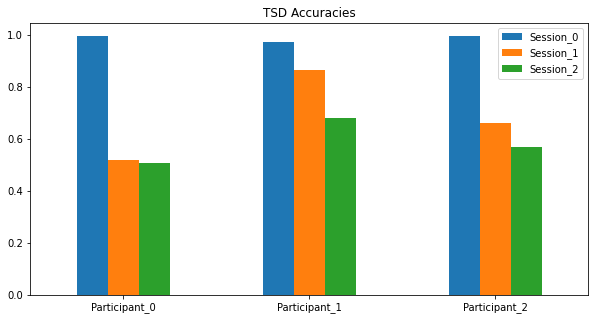

In [16]:
TSD_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("TSD Accuracies")
plt.show()

# 2. DANN

In [17]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_DA import train_DANN, test_DANN_on_training_sessions

In [18]:
path_to_save_to_DANN = "Weights_TSD/DANN"
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycle_for_first_training=40               # #session
number_of_cycles_rest_of_training=40     
path_weights_standard_DNN =path_to_save_to
path_weights_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/DANN"
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515

In [19]:
train_DANN(examples_datasets_train, labels_datasets_train, 
                      num_kernels=num_kernels,
                      path_weights_fine_tuning=path_weights_standard_DNN,
                      number_of_classes=number_of_classes,
                      number_of_cycle_for_first_training=number_of_cycle_for_first_training,
                      number_of_cycles_rest_of_training=number_of_cycles_rest_of_training,
                      batch_size=batch_size,
                      feature_vector_input_length=feature_vector_input_length,
                      path_weights_to_save_to=path_weights_DANN, learning_rate=learning_rate)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 0)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one grou

Accuracy source 0.986979, main loss classifier 0.097795, source classification loss 0.060128, loss domain distinction 0.179884, accuracy domain distinction 0.500000
VALIDATION Loss: 0.04518892 Acc: 0.97727273
Epoch 13 of 500 took 0.257s
Accuracy source 0.985417, main loss classifier 0.095885, source classification loss 0.056279, loss domain distinction 0.180404, accuracy domain distinction 0.500000
VALIDATION Loss: 0.04117551 Acc: 0.98636364
Epoch 14 of 500 took 0.248s
Accuracy source 0.981771, main loss classifier 0.098109, source classification loss 0.060879, loss domain distinction 0.179543, accuracy domain distinction 0.500000
VALIDATION Loss: 0.06138015 Acc: 0.97727273
Epoch 15 of 500 took 0.215s
Accuracy source 0.977083, main loss classifier 0.101982, source classification loss 0.068672, loss domain distinction 0.180250, accuracy domain distinction 0.500000
VALIDATION Loss: 0.03065302 Acc: 0.99090909
Epoch 16 of 500 took 0.213s
Accuracy source 0.983854, main loss classifier 0.095

Accuracy source 0.982292, main loss classifier 0.099381, source classification loss 0.064381, loss domain distinction 0.177820, accuracy domain distinction 0.500000
VALIDATION Loss: 0.04601528 Acc: 0.98181818
Epoch 16 of 500 took 0.212s
Accuracy source 0.988021, main loss classifier 0.094761, source classification loss 0.055053, loss domain distinction 0.179319, accuracy domain distinction 0.500000
VALIDATION Loss: 0.03406387 Acc: 0.99090909
Epoch 17 of 500 took 0.237s
Accuracy source 0.983333, main loss classifier 0.097324, source classification loss 0.059657, loss domain distinction 0.178020, accuracy domain distinction 0.500000
VALIDATION Loss: 0.03045976 Acc: 0.99545455
Training complete in 0m 4s
SHAPE SESSIONS:  (3,)
()
TSD_Network(
  (_network): ModuleList(
    (0): LinearBlocks(
      (fully_connected_1): Linear(in_features=252, out_features=200, bias=True)
      (batch_norm1): BatchNorm1d(200, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (relu1): Leaky

Accuracy source 0.965625, main loss classifier 0.155689, source classification loss 0.117083, loss domain distinction 0.745969, accuracy domain distinction 0.491146
VALIDATION Loss: 0.06633518 Acc: 0.98181818
New best validation loss:  0.06633517891168594
Epoch 1 of 500 took 0.261s
Accuracy source 0.973958, main loss classifier 0.122521, source classification loss 0.097172, loss domain distinction 0.302482, accuracy domain distinction 0.489063
VALIDATION Loss: 0.07927524 Acc: 0.97727273
Epoch 2 of 500 took 0.218s
Accuracy source 0.978125, main loss classifier 0.114792, source classification loss 0.082411, loss domain distinction 0.218465, accuracy domain distinction 0.496875
VALIDATION Loss: 0.07688402 Acc: 0.98181818
Epoch 3 of 500 took 0.218s
Accuracy source 0.972917, main loss classifier 0.120137, source classification loss 0.090315, loss domain distinction 0.201345, accuracy domain distinction 0.496615
VALIDATION Loss: 0.11392841 Acc: 0.96818182
Epoch 4 of 500 took 0.211s
Accuracy 

Accuracy source 0.973958, main loss classifier 0.118170, source classification loss 0.095085, loss domain distinction 0.182789, accuracy domain distinction 0.500000
VALIDATION Loss: 0.05778011 Acc: 0.97727273
Epoch 12 of 500 took 0.214s
Accuracy source 0.968229, main loss classifier 0.118598, source classification loss 0.095209, loss domain distinction 0.182607, accuracy domain distinction 0.499740
VALIDATION Loss: 0.05029126 Acc: 0.99090909
Epoch 13 of 500 took 0.215s
Accuracy source 0.964063, main loss classifier 0.122090, source classification loss 0.101076, loss domain distinction 0.184983, accuracy domain distinction 0.500000
VALIDATION Loss: 0.04493857 Acc: 0.98636364
New best validation loss:  0.04493856802582741
Epoch 14 of 500 took 0.219s
Accuracy source 0.966146, main loss classifier 0.122908, source classification loss 0.103195, loss domain distinction 0.186132, accuracy domain distinction 0.500000
VALIDATION Loss: 0.11403615 Acc: 0.95454545
Epoch 15 of 500 took 0.212s
Accur

Accuracy source 0.945833, main loss classifier 0.155813, source classification loss 0.152956, loss domain distinction 0.459136, accuracy domain distinction 0.493229
VALIDATION Loss: 0.22686878 Acc: 0.92272727
New best validation loss:  0.22686877846717834
Epoch 1 of 500 took 0.216s
Accuracy source 0.957292, main loss classifier 0.138160, source classification loss 0.131113, loss domain distinction 0.232445, accuracy domain distinction 0.499479
VALIDATION Loss: 0.15271020 Acc: 0.94090909
New best validation loss:  0.1527101993560791
Epoch 2 of 500 took 0.216s
Accuracy source 0.957812, main loss classifier 0.136775, source classification loss 0.127756, loss domain distinction 0.201560, accuracy domain distinction 0.500781
VALIDATION Loss: 0.13526992 Acc: 0.93181818
New best validation loss:  0.1352699249982834
Epoch 3 of 500 took 0.214s
Accuracy source 0.952604, main loss classifier 0.143637, source classification loss 0.141133, loss domain distinction 0.190865, accuracy domain distincti

In [20]:
save_path = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"
algo_name = "DANN"
test_DANN_on_training_sessions(examples_datasets_train, labels_datasets_train,
                              feature_vector_input_length=feature_vector_input_length,
                              num_neurons=num_kernels, path_weights_DA=path_weights_DANN,
                              algo_name=algo_name, save_path = save_path,
                              path_weights_normal=path_weights_standard_DNN, number_of_classes=number_of_classes,
                              cycle_for_test=3)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2

In [21]:
results_filename = save_path + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
DANN_acc = results[0]
DANN_acc_overall = np.mean(DANN_acc)
DANN_df = pd.DataFrame(DANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(DANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(DANN_acc.shape[0])])
DANN_df

,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.565455,0.896364,0.692727
Session_2,0.550909,0.750909,0.56


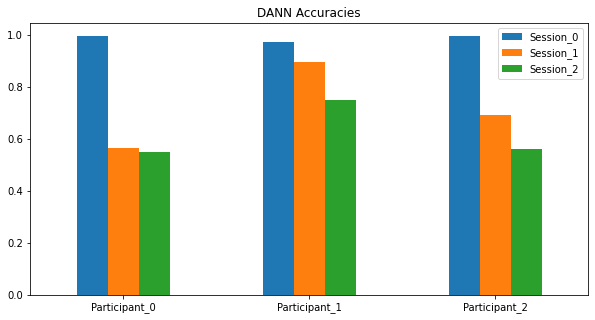

In [22]:
DANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("DANN Accuracies")
plt.show()

# 3. SCADANN

In [23]:
from TrainingsAndEvaluations.ForTrainingSessions.train_tsd_dnn_SCADANN import run_SCADANN_training_sessions, test_network_SLADANN

In [24]:
num_kernels=[200, 200, 200]                        # model layer size 
number_of_cycle_for_first_training=40               # #session
number_of_cycles_rest_of_training=40     
number_of_classes=22
batch_size=128          
feature_vector_input_length=252                     # size of one example 
learning_rate=0.002515
percentage_same_gesture_stable = 0.75 
path_weights_SCADANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/SCADANN"
path_weight_to_save_to = path_weights_SCADANN
path_weights_DANN ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/DANN"
path_weights_start_with = path_weights_DANN
path_weights_TSD ="/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/Weights_TSD/TSD"
path_weights_Normal_training = path_weights_TSD
algo_name = "SCADANN"

In [25]:
run_SCADANN_training_sessions(examples_datasets=examples_datasets_train, labels_datasets=labels_datasets_train,
                              num_kernels=num_kernels, feature_vector_input_length=feature_vector_input_length,
                              path_weights_to_save_to=path_weight_to_save_to,
                              path_weights_Adversarial_training=path_weights_start_with,
                              path_weights_Normal_training=path_weights_Normal_training,
                              number_of_cycle_for_first_training=40, number_of_cycles_rest_of_training=40,
                              number_of_classes=number_of_classes,
                              learning_rate=learning_rate)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (2200, 252)    (2200,)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (2200, 252)    (2200,)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (2200, 252)    (2200,)
dataloaders: 
   train  (1, 3)
   valid  (0,)
   test  (1, 0)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (0,)    (0,)
       one group XY train (2200, 252)    (2200,)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (22

Finish segment dataset
Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.76   AFTER:  1.0  len before:  25   len after:  6
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.4   AFTER:  0.4  len before:  25   len after:  25
BEFORE:  0.2   AFTER:  0.0  len before:  25   len after:  17
BEFORE:  0.24   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.24   AFTER:  0.44  len before:  25   len after:  25
BEFORE:  0.92   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.0   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.44   AFTER:  0.44  len before:  25   len after:  25
BEFORE:  0.72   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.56   AFTER:  1.0  len before:  25   len after:  3
BEFORE:  0.28   AFTER:  0.56  len before:  25   len after:  25
BEFORE:  0.84   AFTER:  1.0  le

Accuracy total 0.931726, main loss classifier 0.329933, source accuracy 0.978940 source classification loss 0.079149, target accuracy 0.884511 target loss 0.371053 accuracy domain distinction 0.500000 loss domain distinction 1.048322,
VALIDATION Loss: 0.30001787 Acc: 0.89008043
Epoch 10 of 500 took 0.303s
Accuracy total 0.929008, main loss classifier 0.332596, source accuracy 0.969429 source classification loss 0.092397, target accuracy 0.888587 target loss 0.364989 accuracy domain distinction 0.500000 loss domain distinction 1.039031,
VALIDATION Loss: 0.21787400 Acc: 0.93029491
Epoch 11 of 500 took 0.301s
Accuracy total 0.930027, main loss classifier 0.323317, source accuracy 0.974185 source classification loss 0.085984, target accuracy 0.885870 target loss 0.352147 accuracy domain distinction 0.500000 loss domain distinction 1.042517,
VALIDATION Loss: 0.20190769 Acc: 0.93565684
Epoch 12 of 500 took 0.302s
Accuracy total 0.929348, main loss classifier 0.331878, source accuracy 0.98029

Accuracy total 0.957201, main loss classifier 0.246717, source accuracy 0.985734 source classification loss 0.055297, target accuracy 0.928668 target loss 0.232004 accuracy domain distinction 0.500000 loss domain distinction 1.030661,
VALIDATION Loss: 0.13835669 Acc: 0.95710456
New best validation loss:  0.13835668501754603
Epoch 36 of 500 took 0.304s
Accuracy total 0.949049, main loss classifier 0.257777, source accuracy 0.980299 source classification loss 0.065718, target accuracy 0.917799 target loss 0.244676 accuracy domain distinction 0.500000 loss domain distinction 1.025796,
VALIDATION Loss: 0.16292043 Acc: 0.9463807
Epoch 37 of 500 took 0.305s
Accuracy total 0.950747, main loss classifier 0.255634, source accuracy 0.987772 source classification loss 0.052835, target accuracy 0.913723 target loss 0.253952 accuracy domain distinction 0.500000 loss domain distinction 1.022400,
VALIDATION Loss: 0.17122754 Acc: 0.94101877
Epoch 38 of 500 took 0.303s
Accuracy total 0.952785, main los

Finish pseudo_labels
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.88   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.6   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.92   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.48   AFTER:  0.52  len before:  25   len after:  25
BEFORE:  0.12   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.48   AFTER:  0.24  len before:  25   len after:  25
BEFORE:  0.6   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.16   AFTER:  0.0  len before:  25   len after:  1
BEFORE:  0.0   AFTER:  0.0  len before:  25   len after:  7
BEFORE:  0.92   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.76   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.0   AFTER:  0.0  len before:  25   len after

/home/laiy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/laiy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Accuracy total 0.822917, main loss classifier 0.757164, source accuracy 0.861607 source classification loss 0.496487, target accuracy 0.784226 target loss 0.801350 accuracy domain distinction 0.500000 loss domain distinction 1.082458,
VALIDATION Loss: 0.33678210 Acc: 0.90670554
New best validation loss:  0.336782102783521
Epoch 2 of 500 took 0.331s
Accuracy total 0.835193, main loss classifier 0.631437, source accuracy 0.864583 source classification loss 0.439209, target accuracy 0.805804 target loss 0.612495 accuracy domain distinction 0.500000 loss domain distinction 1.055850,
VALIDATION Loss: 0.26353565 Acc: 0.90379009
New best validation loss:  0.26353564858436584
Epoch 3 of 500 took 0.279s
Accuracy total 0.850074, main loss classifier 0.579084, source accuracy 0.872768 source classification loss 0.376787, target accuracy 0.827381 target loss 0.572096 accuracy domain distinction 0.500000 loss domain distinction 1.046429,
VALIDATION Loss: 0.29285687 Acc: 0.90087464
Epoch 4 of 500 to

Accuracy total 0.914062, main loss classifier 0.384759, source accuracy 0.935268 source classification loss 0.235121, target accuracy 0.892857 target loss 0.327926 accuracy domain distinction 0.500000 loss domain distinction 1.032353,
VALIDATION Loss: 0.15271799 Acc: 0.95043732
Epoch 28 of 500 took 0.284s
Accuracy total 0.913690, main loss classifier 0.371400, source accuracy 0.927083 source classification loss 0.221703, target accuracy 0.900298 target loss 0.314886 accuracy domain distinction 0.500000 loss domain distinction 1.031058,
VALIDATION Loss: 0.20227192 Acc: 0.93586006
Epoch 29 of 500 took 0.277s
Accuracy total 0.912574, main loss classifier 0.367236, source accuracy 0.919643 source classification loss 0.235847, target accuracy 0.905506 target loss 0.292307 accuracy domain distinction 0.500000 loss domain distinction 1.031592,
VALIDATION Loss: 0.22328232 Acc: 0.9154519
Epoch 30 of 500 took 0.280s
Accuracy total 0.914807, main loss classifier 0.373799, source accuracy 0.935268

Accuracy total 0.920373, main loss classifier 0.383602, source accuracy 0.972356 source classification loss 0.093593, target accuracy 0.868389 target loss 0.428674 accuracy domain distinction 0.497596 loss domain distinction 1.224688,
VALIDATION Loss: 0.12108456 Acc: 0.95432692
New best validation loss:  0.12108456476458482
Epoch 2 of 500 took 0.345s
Accuracy total 0.924279, main loss classifier 0.344631, source accuracy 0.967548 source classification loss 0.096964, target accuracy 0.881010 target loss 0.363061 accuracy domain distinction 0.498498 loss domain distinction 1.146188,
VALIDATION Loss: 0.13890789 Acc: 0.95432692
Epoch 3 of 500 took 0.342s
Accuracy total 0.940805, main loss classifier 0.319007, source accuracy 0.977163 source classification loss 0.080367, target accuracy 0.904447 target loss 0.332481 accuracy domain distinction 0.499399 loss domain distinction 1.125831,
VALIDATION Loss: 0.09809347 Acc: 0.96875
New best validation loss:  0.0980934692280633
Epoch 4 of 500 took

Accuracy total 0.956430, main loss classifier 0.242077, source accuracy 0.975962 source classification loss 0.078769, target accuracy 0.936899 target loss 0.192050 accuracy domain distinction 0.500300 loss domain distinction 1.066671,
VALIDATION Loss: 0.12297426 Acc: 0.95913462
Epoch 28 of 500 took 0.340s
Accuracy total 0.959736, main loss classifier 0.225441, source accuracy 0.977764 source classification loss 0.071691, target accuracy 0.941707 target loss 0.165411 accuracy domain distinction 0.499099 loss domain distinction 1.068898,
VALIDATION Loss: 0.11866431 Acc: 0.95432692
Epoch 29 of 500 took 0.345s
Accuracy total 0.955829, main loss classifier 0.246464, source accuracy 0.981370 source classification loss 0.069437, target accuracy 0.930288 target loss 0.211382 accuracy domain distinction 0.499399 loss domain distinction 1.060540,
VALIDATION Loss: 0.07786741 Acc: 0.97596154
Epoch 30 of 500 took 0.342s
Training complete in 0m 10s
['participant_1', 'participant_2', 'participant_0']

BEFORE:  0.92   AFTER:  1.0  len before:  25   len after:  16
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.76   AFTER:  1.0  len before:  25   len after:  17
BEFORE:  0.24   AFTER:  0.04  len before:  25   len after:  25
BEFORE:  0.2   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.84   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.88   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.84   AFTER:  1.0  len before:  25   len after:  17
BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.56   AFTER:  1.0  len before:  25   len after:  8
BEFORE:  0.56   AFTER:  1.0  len before:  25   len after:  5
BEFORE:  1.0   

Accuracy total 0.931966, main loss classifier 0.305469, source accuracy 0.945312 source classification loss 0.160226, target accuracy 0.918620 target loss 0.239925 accuracy domain distinction 0.500000 loss domain distinction 1.053933,
VALIDATION Loss: 0.23833833 Acc: 0.9213198
Epoch 12 of 500 took 0.318s
Accuracy total 0.931641, main loss classifier 0.311261, source accuracy 0.942708 source classification loss 0.172966, target accuracy 0.920573 target loss 0.239000 accuracy domain distinction 0.500000 loss domain distinction 1.052780,
VALIDATION Loss: 0.10964042 Acc: 0.95177665
Epoch 13 of 500 took 0.316s
Accuracy total 0.933594, main loss classifier 0.298367, source accuracy 0.936198 source classification loss 0.185789, target accuracy 0.930990 target loss 0.201040 accuracy domain distinction 0.500000 loss domain distinction 1.049525,
VALIDATION Loss: 0.11569609 Acc: 0.95177665
Epoch 14 of 500 took 0.321s
Accuracy total 0.935547, main loss classifier 0.295257, source accuracy 0.939453

Accuracy total 0.957357, main loss classifier 0.230963, source accuracy 0.961589 source classification loss 0.105411, target accuracy 0.953125 target loss 0.150597 accuracy domain distinction 0.500000 loss domain distinction 1.029593,
VALIDATION Loss: 0.05713374 Acc: 0.97461929
Epoch 38 of 500 took 0.317s
Accuracy total 0.963867, main loss classifier 0.225168, source accuracy 0.966797 source classification loss 0.111527, target accuracy 0.960938 target loss 0.133342 accuracy domain distinction 0.500000 loss domain distinction 1.027338,
VALIDATION Loss: 0.10505826 Acc: 0.95431472
Epoch 39 of 500 took 0.319s
Accuracy total 0.965169, main loss classifier 0.207786, source accuracy 0.970052 source classification loss 0.091462, target accuracy 0.960286 target loss 0.118010 accuracy domain distinction 0.500000 loss domain distinction 1.030500,
VALIDATION Loss: 0.07052546 Acc: 0.97715736
Epoch 40 of 500 took 0.324s
Accuracy total 0.965820, main loss classifier 0.210851, source accuracy 0.97070

Accuracy total 0.881250, main loss classifier 0.535353, source accuracy 0.960000 source classification loss 0.121401, target accuracy 0.802500 target loss 0.711161 accuracy domain distinction 0.499688 loss domain distinction 1.190726,
VALIDATION Loss: 0.31359766 Acc: 0.89356436
New best validation loss:  0.31359765997954775
Epoch 2 of 500 took 0.333s
Accuracy total 0.890625, main loss classifier 0.494684, source accuracy 0.961250 source classification loss 0.120492, target accuracy 0.820000 target loss 0.648502 accuracy domain distinction 0.499688 loss domain distinction 1.101870,
VALIDATION Loss: 0.33323558 Acc: 0.88118812
Epoch 3 of 500 took 0.331s
Accuracy total 0.891875, main loss classifier 0.474388, source accuracy 0.965625 source classification loss 0.114041, target accuracy 0.818125 target loss 0.619601 accuracy domain distinction 0.500313 loss domain distinction 1.075672,
VALIDATION Loss: 0.35297051 Acc: 0.87871287
Epoch 4 of 500 took 0.330s
Accuracy total 0.892188, main loss 

Accuracy total 0.921875, main loss classifier 0.351128, source accuracy 0.962500 source classification loss 0.114344, target accuracy 0.881250 target loss 0.378711 accuracy domain distinction 0.500000 loss domain distinction 1.046006,
VALIDATION Loss: 0.26314661 Acc: 0.90841584
Epoch 28 of 500 took 0.332s
Accuracy total 0.924063, main loss classifier 0.345464, source accuracy 0.970000 source classification loss 0.100203, target accuracy 0.878125 target loss 0.380157 accuracy domain distinction 0.500000 loss domain distinction 1.052842,
VALIDATION Loss: 0.22579571 Acc: 0.91584158
Epoch 29 of 500 took 0.327s
Accuracy total 0.915000, main loss classifier 0.373391, source accuracy 0.968750 source classification loss 0.104624, target accuracy 0.861250 target loss 0.433431 accuracy domain distinction 0.500000 loss domain distinction 1.043636,
VALIDATION Loss: 0.25402844 Acc: 0.90594059
Epoch 30 of 500 took 0.330s
Accuracy total 0.922813, main loss classifier 0.349884, source accuracy 0.96937

BEFORE:  1.0   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.2   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.8   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.72   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.76   AFTER:  0.76  len before:  25   len after:  25
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.52   AFTER:  1.0  len before:  25   len after:  12
BEFORE:  0.12   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.92   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.2   AFTER:  0.0  len before:  25   len after:  25
BEFORE:  0.24   AFTER:  0.24  len before:  25   len after:  25
BEFORE:  0.72   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  0.72   AFTER:  0.88  len before:  25   len after:  25
BEFORE:  0.44   AFTER:  0.2  len before:  25   len after:  25
BEFORE:  0.44   AFTER:  0.6  len before:  25   len after:  25
BEFORE:  0.96   AFTER:  1.0  len before:  25   len after:  25
BEFORE:  

Accuracy total 0.849609, main loss classifier 0.572490, source accuracy 0.893229 source classification loss 0.335486, target accuracy 0.805990 target loss 0.592197 accuracy domain distinction 0.502279 loss domain distinction 1.086489,
VALIDATION Loss: 0.21862037 Acc: 0.90886076
New best validation loss:  0.2186203705413001
Epoch 10 of 500 took 0.318s
Accuracy total 0.845052, main loss classifier 0.576406, source accuracy 0.877604 source classification loss 0.341942, target accuracy 0.812500 target loss 0.596416 accuracy domain distinction 0.500326 loss domain distinction 1.072276,
VALIDATION Loss: 0.33463891 Acc: 0.84556962
Epoch 11 of 500 took 0.317s
Accuracy total 0.862305, main loss classifier 0.544476, source accuracy 0.884766 source classification loss 0.353357, target accuracy 0.839844 target loss 0.517150 accuracy domain distinction 0.500000 loss domain distinction 1.092223,
VALIDATION Loss: 0.30939912 Acc: 0.88860759
Epoch 12 of 500 took 0.317s
Accuracy total 0.839193, main los

In [26]:
save_path = "/home/laiy/gitrepos/msr_final/LongTermEMG_myo/TrainingsAndEvaluations/ForTrainingSessions/results_tsd"
test_network_SLADANN(examples_datasets_train=examples_datasets_train, labels_datasets_train=labels_datasets_train,
                     num_neurons=num_kernels, feature_vector_input_length=feature_vector_input_length,
                     path_weights_SCADANN =path_weight_to_save_to, path_weights_normal=path_weights_Normal_training,
                     algo_name=algo_name, cycle_test=3, 
                     number_of_classes=number_of_classes, save_path = save_path)

GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  1
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
   GET one training_index_examples  (40, 550, 252)  at  2
   GOT one group XY  (2200, 252)    (2200,)
       one group XY test  (550, 252)    (550, 252)
       one group XY train (1980, 252)    (1980,)
       one group XY valid (220, 252)    (220, 252)
dataloaders: 
   train  (1, 3)
   valid  (1, 3)
   test  (1, 3)
GET one participant_examples  (3, 40, 550, 252)
   GET one training_index_examples  (40, 550, 252)  at  0
   GOT one group XY  (2

In [27]:
results_filename = save_path + '/predictions_' + algo_name + ".npy"
results = np.load(results_filename, allow_pickle=True)
SCADANN_acc = results[0]
SCADANN_acc_overall = np.mean(SCADANN_acc)
SCADANN_df = pd.DataFrame(SCADANN_acc.transpose(), 
                       index = [f'Session_{i}' for i in range(SCADANN_acc.shape[1])],
                        columns = [f'Participant_{j}' for j in range(SCADANN_acc.shape[0])])
SCADANN_df

,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.58,0.907273,0.732727
Session_2,0.563636,0.827273,0.589091


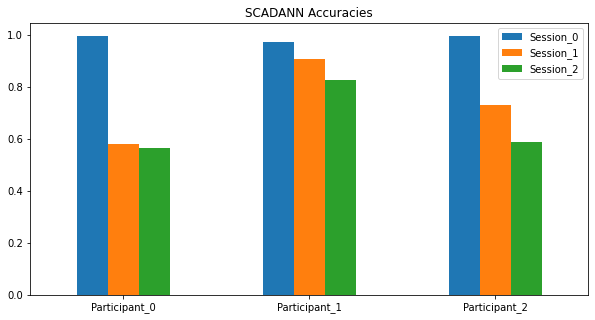

In [28]:
SCADANN_df.transpose().plot.bar(rot=0, figsize=(10,5))
plt.title("SCADANN Accuracies")
plt.show()

# Conclusion

In [29]:
print("TSD")
display(TSD_df)
print("DANN")
display(DANN_df)
print("SCADANN")
display(SCADANN_df)

TSD


,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.518182,0.867273,0.66
Session_2,0.509091,0.681818,0.570909


DANN


,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.565455,0.896364,0.692727
Session_2,0.550909,0.750909,0.56


SCADANN


,Participant_0,Participant_1,Participant_2
Session_0,0.996364,0.974545,0.996364
Session_1,0.58,0.907273,0.732727
Session_2,0.563636,0.827273,0.589091


In [30]:
overall_acc_df = pd.DataFrame([TSD_acc_overall, DANN_acc_overall, SCADANN_acc_overall],
                             index = ["TSD", "DANN", "SCADANN"],
                             columns = ["Overall_Acc"])
overall_acc_df

,Overall_Acc
TSD,0.752727
DANN,0.775960
SCADANN,0.796364


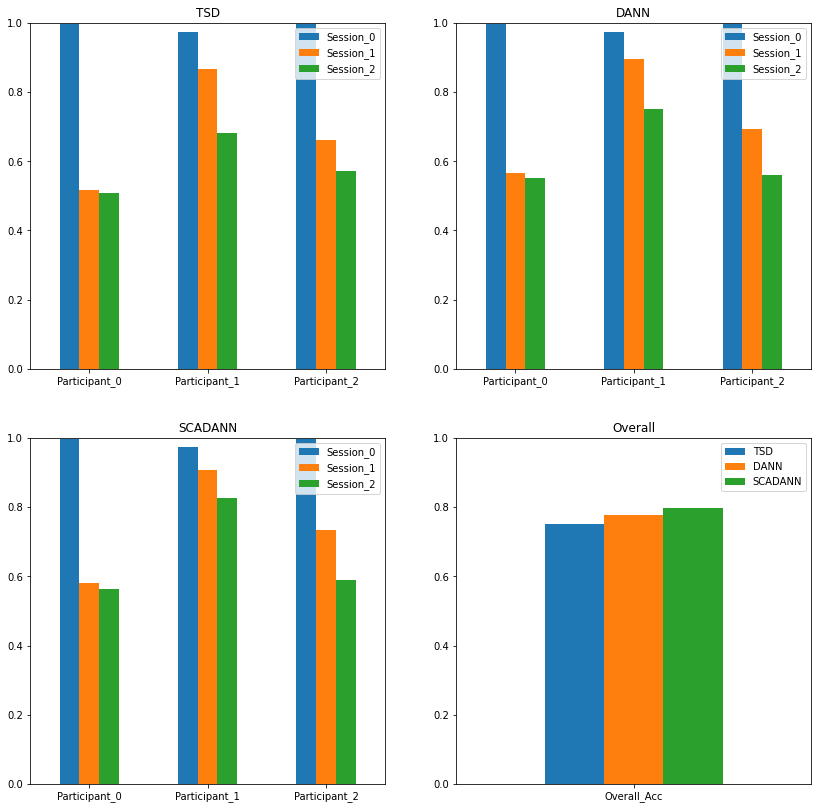

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,14))
acc_list = [TSD_df, DANN_df, SCADANN_df, overall_acc_df]
title_list = ["TSD", "DANN", "SCADANN", "Overall"]
for idx, ax in enumerate(axes.reshape(-1)): 
    acc_list[idx].transpose().plot.bar(ax = ax, rot=0)
    ax.set_title(title_list[idx])
    ax.set_ylim([0, 1.0])